Importar librerias

In [1]:
import os
import sys
import random
from src.config import *
from src.data import *


Mendeley 224

╒═════════╤══════╤══════╤══════╤═════╤═════╕
│ Clase   │    0 │    1 │    2 │   3 │   4 │
╞═════════╪══════╪══════╪══════╪═════╪═════╡
│ train   │ 2286 │ 1046 │ 1516 │ 757 │ 173 │
├─────────┼──────┼──────┼──────┼─────┼─────┤
│ val     │  328 │  153 │  212 │ 106 │  27 │
├─────────┼──────┼──────┼──────┼─────┼─────┤
│ test    │  639 │  296 │  447 │ 223 │  51 │
╘═════════╧══════╧══════╧══════╧═════╧═════╛


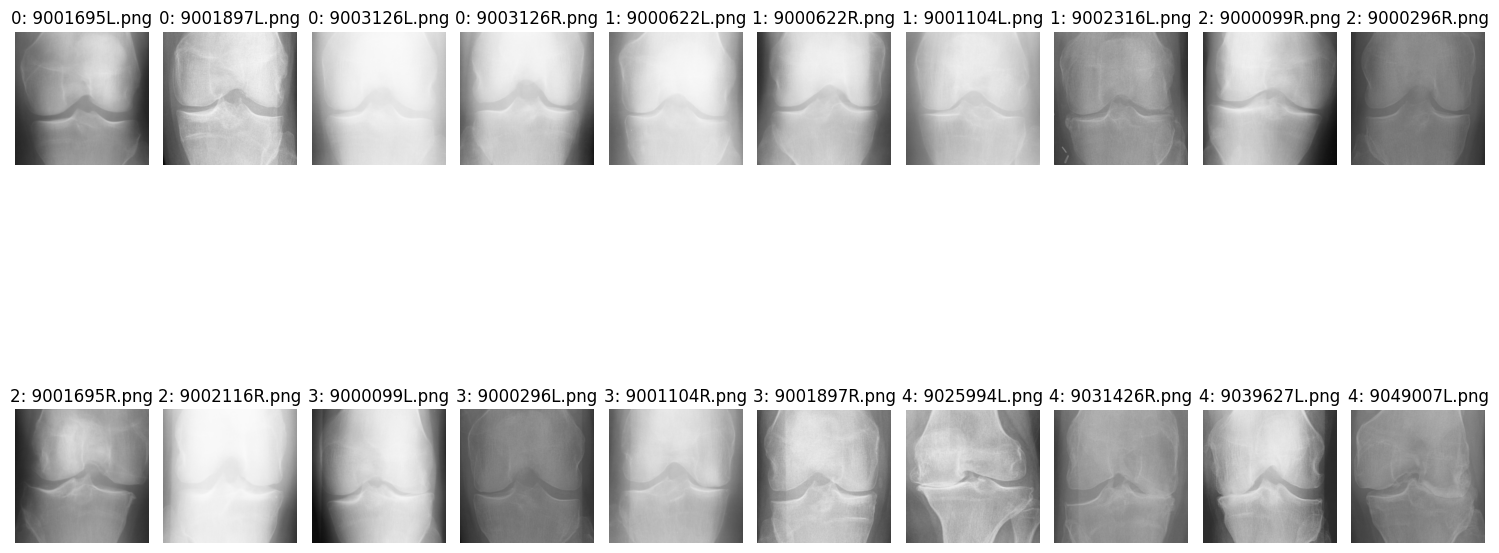

In [2]:
img = explorar_split_data(MENDELEY_OAI_224_SPLIT_PATH)
mostrar_imagenes(os.path.join(MENDELEY_OAI_224_SPLIT_PATH, 'train'))


╒═════════╤════════════╕
│   Clase │   Cantidad │
╞═════════╪════════════╡
│       0 │        514 │
├─────────┼────────────┤
│       1 │        477 │
├─────────┼────────────┤
│       2 │        232 │
├─────────┼────────────┤
│       3 │        221 │
├─────────┼────────────┤
│       4 │        206 │
╘═════════╧════════════╛


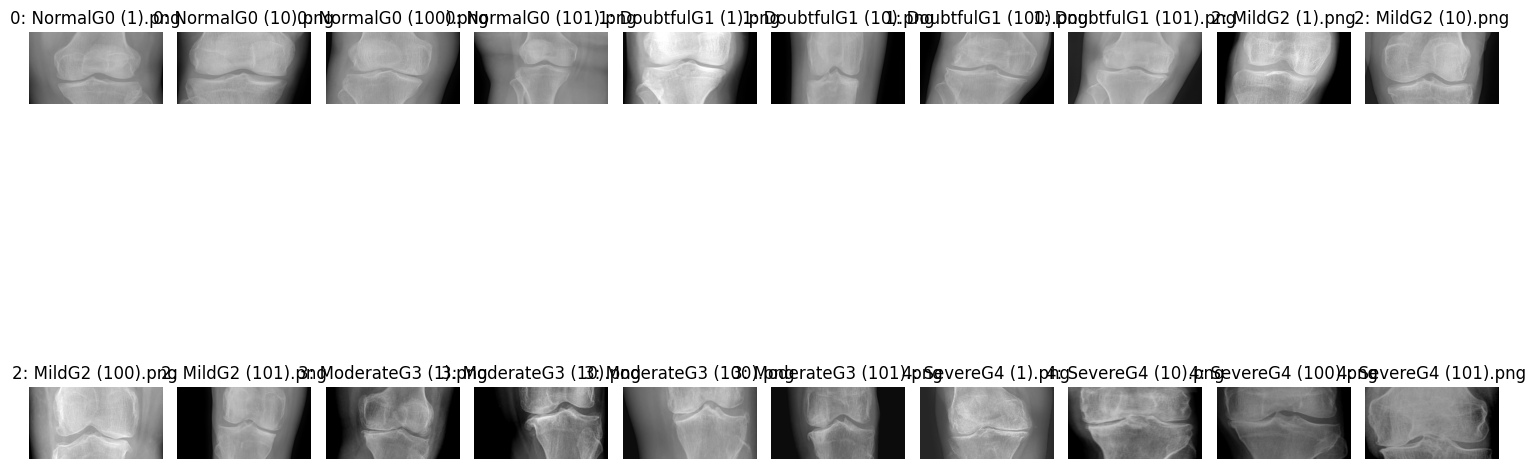

In [3]:
img = explorar_data(MENDELEY_EXPERT1_PATH)
mostrar_imagenes(MENDELEY_EXPERT1_PATH)

╒═════════╤════════════╕
│   Clase │   Cantidad │
╞═════════╪════════════╡
│       0 │        503 │
├─────────┼────────────┤
│       1 │        488 │
├─────────┼────────────┤
│       2 │        232 │
├─────────┼────────────┤
│       3 │        221 │
├─────────┼────────────┤
│       4 │        206 │
╘═════════╧════════════╛


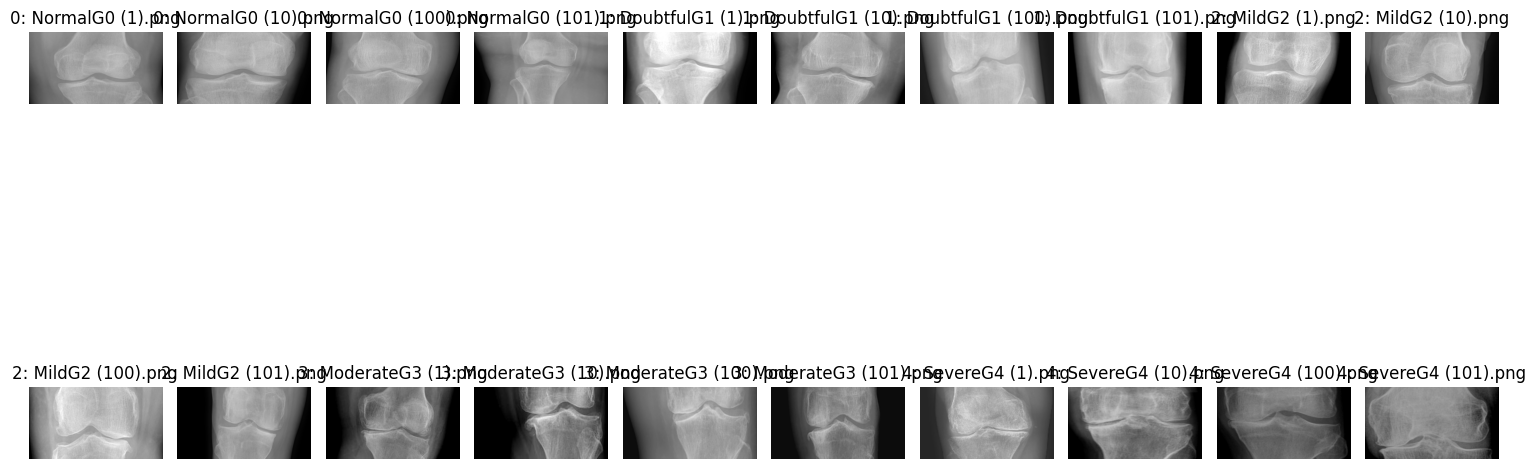

In [4]:
img = explorar_data(MENDELEY_EXPERT2_PATH)
mostrar_imagenes(MENDELEY_EXPERT2_PATH)

In [9]:
# cargar modelo

model_path = 'dataset\mendeleyOAI_dataset\ClsKLData\models\model_best\densenet121\densenet-121-SGD-0\6-0.65-0.673-0.548.pth'
#comprobar path
model = torch.load(model_path)


OSError: [Errno 22] Invalid argument: 'dataset\\mendeleyOAI_dataset\\ClsKLData\\models\\model_best\\densenet121\\densenet-121-SGD-0\x06-0.65-0.673-0.548.pth'